In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import NearestNeighbors

In [ ]:
import os 
nueva_ruta = r'C:\Users\Luis\Documents\GitHub\TFM_KSCHOOL\Luis\PreModelado_TFM_Palas\Noviembre\PreModelado_Palas'
os.chdir(nueva_ruta)
print("Nueva ruta actual:", os.getcwd())


In [ ]:
df_form3 = pd.read_csv('df_scaled_formularios_3.0.csv')
df_palas3 = pd.read_csv('df_scaled_palas_3.0.csv')

In [10]:
# Seleccionar una fila aleatoria de df_form
random_row = df_form3.sample(1)

# Extraer las coordenadas X e Y de la fila aleatoria
x_random = random_row['Score_Escalar_Lesion'].values[0]
y_random = random_row['Score_Escalar_Nivel'].values[0]

# Filtrar filas en base al sexo indicado en df_form
sexo_form = df_form3["Indique su sexo"].iloc[0]  # Supongamos que tomas el sexo de la primera fila de df_form

if sexo_form == "hombre":
    # Filtrar df_palas para incluir solo jugadores "hombre" o "mixta"
    df_palas_filtrado = df_palas3[(df_palas3["Jugador"] == "hombre") | (df_palas3["Jugador"] == "mixta")]
elif sexo_form == "mujer":
    # Filtrar df_palas para incluir solo jugadores "mujer" o "mixta"
    df_palas_filtrado = df_palas3[(df_palas3["Jugador"] == "mujer") | (df_palas3["Jugador"] == "mixta")]
else:
    # En caso de no especificar un sexo, incluir todo el DataFrame
    df_palas_filtrado = df_palas3


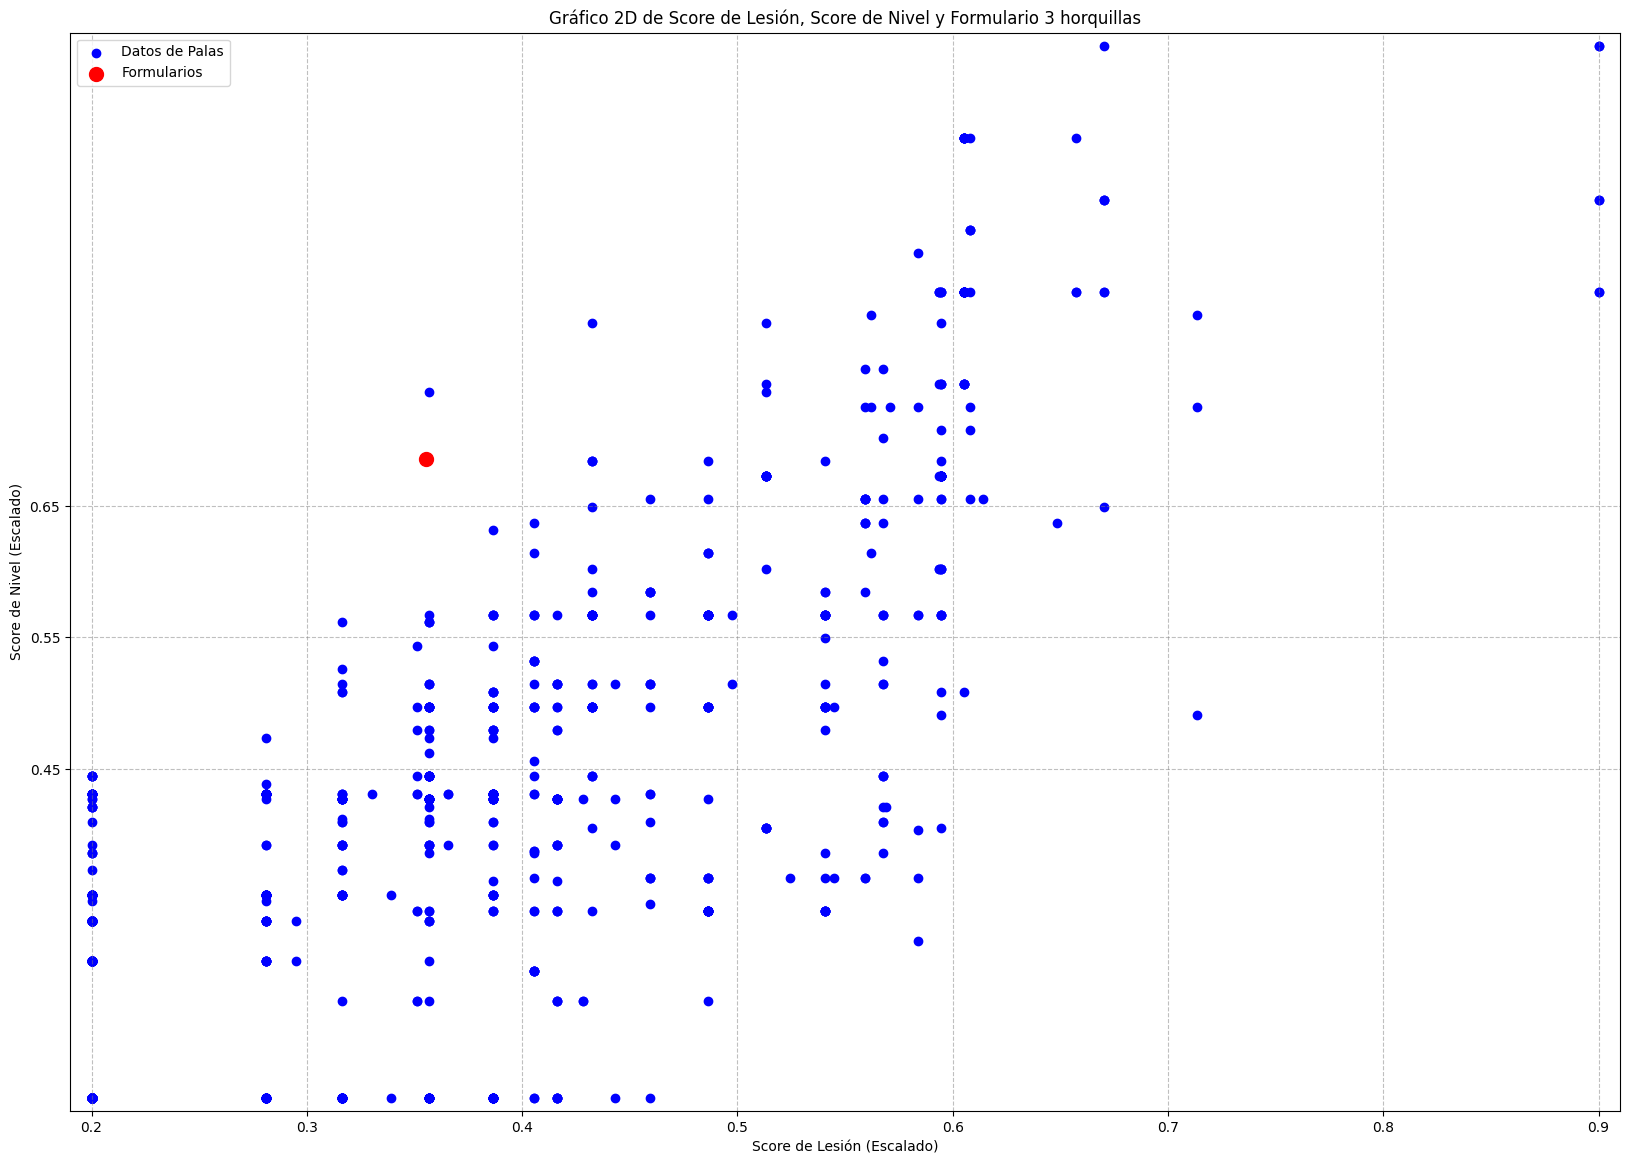

In [11]:

# Crear figura
fig = plt.figure(figsize=(20, 14))

# Crear un gráfico en 2D
ax = fig.add_subplot(111)

# Definir los valores de cada eje para el DataFrame principal (df_palas)
x = df_palas3['score_lesion_ajustado']
y = df_palas3['score_nivel_ajustado']

# Crear el gráfico de dispersión 2D para df_palas
ax.scatter(x, y, color='blue', label='Datos de Palas')

# Crear los puntos adicionales
ax.scatter([x_random], [y_random],
           color='red', s=100, label='Formularios')

# Calcular los límites con buffer
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
buffer = 0.01  # Cambia este valor para ajustar el tamaño del margen

# Ajustar límites de los ejes con el buffer
ax.set_xlim(x_min - buffer, x_max + buffer)
ax.set_ylim(y_min - buffer, y_max + buffer)

# Añadir etiquetas a los ejes
ax.set_xlabel('Score de Lesión (Escalado)')
ax.set_ylabel('Score de Nivel (Escalado)')

# Título del gráfico
ax.set_title('Gráfico 2D de Score de Lesión, Score de Nivel y Formulario 3 horquillas')

# Añadir leyenda para diferenciar los conjuntos de puntos
ax.legend()

# Configurar las particiones de Y para solo mostrar en 0.45, 0.55, 0.65
ax.set_yticks([0.45, 0.55, 0.65])  # Solo las marcas deseadas en Y
ax.grid(True, which='both', axis='both', linestyle='--', color='gray', alpha=0.5)

# Mostrar el gráfico
plt.show()

In [12]:
label_mapping = {
    "Balance": {"No data": 0, "bajo": 1, "medio": 2, "alto": 3},
    "Nucleo": {"No data": 0, "foam": 1, "medium eva": 2, "hard eva": 3, "soft eva": 4},
    "Cara": {"No data": 0, "fibra de vidrio": 1, "mix": 2, "fibra de carbono": 3},
    "Dureza": {"No data": 0, "blanda": 1, "media": 2, "dura": 3},
    "Nivel de Juego": {"No data": 0, "principiante": 1, "avanzado": 2, "pro": 3},
    "Forma": {"No data": 0, "redonda": 1, "lágrima": 2, "diamante": 3},
    "Superficie": {"No data": 0, "lisa": 1, "rugosa": 2},
    "Tipo de Juego": {"No data": 0, "control": 1, "polivalente": 2, "potencia": 3},
}

# Función para invertir un diccionario
def invertir_label_mapping(label_mapping):
    inverted_mapping = {}
    for key, value_dict in label_mapping.items():
        inverted_mapping[key] = {v: k for k, v in value_dict.items()}
    return inverted_mapping

# Invertir el diccionario
inverted_label_mapping = invertir_label_mapping(label_mapping)

In [13]:
def encontrar_vecinos_mas_cercanos_knn_2d(df_palas3, x_random, y_random, considerar_precio, precio_maximo):
    knn_features = ['score_lesion', 'score_nivel']
    
    if considerar_precio:
        knn_features.append('Precio')
        df_palas3 = df_palas3[df_palas3['Precio'] <= precio_maximo]
    
    knn = NearestNeighbors(n_neighbors=3)
    knn.fit(df_palas3[knn_features])
    
    # Crear un punto de referencia con nombres de columnas
    reference_point = pd.DataFrame(
        [[x_random, y_random] + ([precio_maximo] if considerar_precio else [])],
        columns=knn_features
    )
    
    distances, indices = knn.kneighbors(reference_point)
    
    palas_recomendadas = df_palas3.iloc[indices[0]].copy()  # Copiar para evitar problemas de modificación
    

    # Mapear valores numéricos a etiquetas descriptivas
    palas_recomendadas["Nivel de Juego"] = palas_recomendadas["Nivel de Juego"].map(inverted_label_mapping["Nivel de Juego"])
    palas_recomendadas["Tipo de Juego"] = palas_recomendadas["Tipo de Juego"].map(inverted_label_mapping["Tipo de Juego"])
    palas_recomendadas["Balance"] = palas_recomendadas["Balance"].map(inverted_label_mapping["Balance"])
    
    return palas_recomendadas[['Palas', 'Nivel de Juego', 'Tipo de Juego', 'Balance', 'Precio']]




In [14]:
recomendaciones = encontrar_vecinos_mas_cercanos_knn_2d(
    df_palas3=df_palas3, 
    x_random=x_random, 
    y_random=y_random, 
    considerar_precio=False, 
    precio_maximo=200
)

# Ver las recomendaciones
if recomendaciones is not None:
    print(recomendaciones)

                                             Palas Nivel de Juego  \
377                             WILSON CUPRA PADEL            pro   
185  ADIDAS ADIPOWER CTRL MTW PRO EDT BY ÁLEX RUIZ            pro   
413              BLACK CROWN PATRON EVOLUTION 2024       avanzado   

    Tipo de Juego Balance  Precio  
377   polivalente   medio  104.95  
185       control    alto  305.95  
413   polivalente   medio  184.95  


In [15]:
import numpy as np
import pandas as pd

# Definir la función que determina el cuadrante y selecciona las palas correspondientes
def obtener_palas_por_cuadrante(df_palas3, x_random, y_random):
    # Redefinir las particiones en X (de 0.2 a 0.9 con intervalos de 0.1)
    particiones_x = np.arange(0.2, 1.0, 0.1)  # 0.2, 0.3, ..., 0.9
    
    # Redefinir las particiones en Y (de 0.2 a 0.9 con las divisiones 0.45, 0.55, 0.65)
    particiones_y = [0.2, 0.45, 0.55, 0.65, 0.9]
    
    # Mostrar las particiones y los valores aleatorios para diagnóstico
    print(f"Particiones X: {particiones_x}")
    print(f"Particiones Y: {particiones_y}")
    print(f"Valor aleatorio X: {x_random}")
    print(f"Valor aleatorio Y: {y_random}")

    # Determinar en qué partición de X cae el punto aleatorio
    x_cuadrante = None
    for i in range(len(particiones_x) - 1):
        if particiones_x[i] <= x_random < particiones_x[i + 1]:
            x_cuadrante = (particiones_x[i], particiones_x[i + 1])
            break
    
    # Si x_random no está dentro de las particiones, asignar el valor más cercano
    if x_cuadrante is None:
        x_cuadrante = (particiones_x[-2], particiones_x[-1])  # Asignamos el último intervalo de X

    # Determinar en qué partición de Y cae el punto aleatorio
    y_cuadrante = None
    y_cuadrante_upper = None  # Para definir el límite superior del cuadrante
    for i in range(len(particiones_y) - 1):
        if particiones_y[i] <= y_random < particiones_y[i + 1]:
            y_cuadrante = particiones_y[i]
            y_cuadrante_upper = particiones_y[i + 1]  # Asignar límite superior
            break
    
    # Si y_random no está dentro de las particiones, asignar el valor más cercano
    if y_cuadrante is None:
        y_cuadrante = particiones_y[-1]  # Asignamos el último valor de Y
        y_cuadrante_upper = particiones_y[-1]  # También el límite superior sería ese valor

    print(f"Cuadrante X: {x_cuadrante}")
    print(f"Cuadrante Y: ({y_cuadrante}, {y_cuadrante_upper})")

    # Filtrar las palas dentro de este cuadrante
    df_palas_filtrado = df_palas3[
        (df_palas3['score_lesion_ajustado'] >= x_cuadrante[0]) & (df_palas3['score_lesion_ajustado'] < x_cuadrante[1]) &
        (df_palas3['score_nivel_ajustado'] >= y_cuadrante) & (df_palas3['score_nivel_ajustado'] < y_cuadrante_upper)
    ]
    
    # Si hay palas recomendadas, devolverlas
    if not df_palas_filtrado.empty:
        return df_palas_filtrado[['Palas', 'score_lesion_ajustado', 'score_nivel_ajustado']]
    else:
        return pd.DataFrame(columns=['Palas', 'score_lesion_ajustado', 'score_nivel_ajustado'])

# Llamar a la función para obtener las palas recomendadas dentro del cuadrante
palas_recomendadas_rejilla = obtener_palas_por_cuadrante(df_palas3, x_random, y_random)

# Mostrar las recomendaciones de palas
print("Palas recomendadas en el cuadrante del punto aleatorio:")
print(palas_recomendadas_rejilla)



Particiones X: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Particiones Y: [0.2, 0.45, 0.55, 0.65, 0.9]
Valor aleatorio X: 0.3555555555555554
Valor aleatorio Y: 0.6857142857142857
Cuadrante X: (0.30000000000000004, 0.4000000000000001)
Cuadrante Y: (0.65, 0.9)
Palas recomendadas en el cuadrante del punto aleatorio:
                                             Palas  score_lesion_ajustado  \
185  ADIDAS ADIPOWER CTRL MTW PRO EDT BY ÁLEX RUIZ               0.356757   

     score_nivel_ajustado  
185              0.736842  
